In [1]:

import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import sklearn.svm as svm # Libreria de sklearn para la obtener el modelo de la maquina de soporte de vectores
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge # Modulo de sklearn para obtener la regresion lineal con regularizacion L2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

### Funciones relacionadas con la carga de datos

In [2]:
def read_dataset_from_csv(path = ''):
    if ( pathlib.Path(path).exists() ):
        df = pd.read_csv(path, delimiter=';')
        return df
    raise Exception('No path provided')

def get_sunspot_dataset(path):
    dataset = read_dataset_from_csv(path)
    X = dataset['sunspot_number'].to_numpy()
    Y = dataset['year'].to_numpy()
    return (X, Y)

def get_years_sunspot_dataset():
     dataset = read_dataset_from_csv("./dataset/SN_y_tot_V2.0.csv")
     X = dataset['sunspot_number'].to_numpy()
     Y = dataset['year'].to_numpy()
     return (X, Y)

def get_ms_sunspot_dataset():
     dataset = read_dataset_from_csv("./dataset/SN_ms_tot_V2.0.csv")
     X = dataset['sunspot_number'].to_numpy()
     Y = dataset['date_in_fraction'].to_numpy()
     return (X, Y)


def get_days_sunspot_dataset():
     dataset = read_dataset_from_csv("./dataset/SN_d_tot_V2.0.csv")
     X = dataset['sunspot_number'].to_numpy()
     Y = dataset['date_in_fraction'].to_numpy()
     return (X, Y)


### Funciones relacionadas con el Preprocesamiento
Se tienen:
- Filtrado de los registros sin observaciones
- Filtrado de los registros anteriores a un año
- Escala de datos con MinMaxScaler
- Transformar los datos para la prediccion del dato siguiente

In [3]:
def remove_rows_without_observation(X,Y):
    bool_filter = X > 0
    X = X[bool_filter]
    Y = Y[bool_filter]
    return X,Y 

def filter_after_year(X: np.ndarray, Y: np.ndarray, after_year=1700):
    dataset_filter  = []
    for i in range(len(X)):
        dataset_filter.append((Y[i] >= after_year))
    X = X[dataset_filter]
    Y = Y[dataset_filter]
    return X, Y

def scale_data(X : np.ndarray, Y : np.ndarray):
	sc = MinMaxScaler()
	X_std = sc.fit_transform(X)
	return (X_std, Y)

def data_to_time_series(X: np.ndarray, n_elements: int):
    inputs = []
    outputs = []
    for i in range(len(X) - n_elements):
      intput_serie = []
      if (len(X) - i > n_elements) :  
        for j in range(n_elements):
            intput_serie.append(X[i+j])
            if ( j == n_elements - 1):
              outputs.append(X[i+n_elements])
      inputs.append(intput_serie)  
    return np.array(inputs)


def preprocess_sunspots_data(raw_sunspots: np.array, raw_date: np.array, year = 1700, n_time_step = 2):

    assert raw_sunspots.shape == raw_date.shape, "Both raws must have the same dimension"

    sunspots_after_removed_rows, date_after_removed_rows = remove_rows_without_observation(raw_sunspots, raw_date)
    sunspots_filtered, date_filtered = filter_after_year(sunspots_after_removed_rows, date_after_removed_rows, year)
    sunsposts_time_series = data_to_time_series(sunspots_filtered, n_time_step)
    sunspots_scaled, dates = scale_data(sunsposts_time_series, date_filtered)

    X = sunspots_scaled[:, 0:n_time_step - 1 ]
    Y = sunspots_scaled[:,n_time_step - 1].reshape(-1,1)
    return X, Y, sunspots_filtered, dates


In [4]:
def plot_sunspot_number(X:np.ndarray,Y:np.ndarray, time_unit, color='green', scatter = False, filled = False):
    alpha= 0.2
    plt.ylabel('Sunspot Number')
    plt.title(f'International Sunspot Number by {time_unit}')
    if (scatter):
        plt.scatter(X,Y, c=color)
        return
    if (filled):
        if len(Y.shape) > 1:
            Y = Y.flatten()
        plt.fill_between(X,Y, color=color, alpha=alpha)
    plt.plot(X, Y, color=color)


In [5]:
def show_mse(y_true:np.ndarray, y_pred:np.ndarray, label = ""):
    assert isinstance(y_true,np.ndarray), "y_true must be a np.array"
    assert isinstance(y_pred,np.ndarray), "y_pred must be a np.array"
    assert len(label) != 0, "Label must be >= 0"
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have same shape"
    print(f"{label} {mean_squared_error(y_true, y_pred)}")



### Regresión Polinomial Vanilla

### Regresión polinomial con Métodos de Kernel

In [ ]:
from enum import Enum

class KernelPolynomialRegression:
    kernel_matrix: np.ndarray = None
    W: np.ndarray = None
    alpha = 0
    coef = 0
    gamma = 0
    X_fit: np.ndarray = None

    def __init__(self, alpha = 0.001, gamma = 1.0, degree = 2, coef = 1):
        self.alpha = alpha
        self.gamma = gamma
        self.degree = degree
        self.coef = coef

    def kernel(self, x_i: np.ndarray, x_j: np.ndarray):
        return (self.gamma*np.dot(x_i, x_j.T) + self.coef )**self.degree

    def __build_kernel_matrix(self, X1 : np.ndarray, X2 : np.ndarray) -> np.ndarray:
        kernel_matrix=np.zeros((X1.shape[0],X2.shape[0]))
        for i, _ in enumerate(kernel_matrix):
            for j, _ in enumerate(kernel_matrix.T):
                kernel_matrix[i,j]=self.kernel(X1[i],X2[j])
        return kernel_matrix
    
    def __apply_regularization_l2(self,kernel_matrix): 
        kernel_matrix_regulated = kernel_matrix.copy() + np.identity(kernel_matrix.shape[0]) * self.alpha
        return kernel_matrix_regulated
        
    
    def fit(self, X : np.ndarray, Y : np.ndarray):
        assert isinstance(X,np.ndarray), "X must be a np.array"
        assert isinstance(Y,np.ndarray), "Y must be a np.array"
        assert X.shape[0] == Y.shape[0], "X and Y must have same len"
        
        self.X_fit = X.copy()
        kernel_matrix = self.__apply_regularization_l2(self.__build_kernel_matrix(X, self.X_fit))
        inv_kernel_matrix = np.linalg.inv(kernel_matrix)
        self.W = np.matmul(Y, inv_kernel_matrix)
        return self.W

    def predict(self, X):

        pred_dim = X.shape[0]
        Y_pred = np.zeros((pred_dim,1))
        kernel_matrix = self.__build_kernel_matrix(X,self.X_fit)
        for i in range(pred_dim):
            Y_pred[i] = np.matmul(self.W, kernel_matrix[i])
        return Y_pred



## Caso de años

### Carga de manchas solares por años

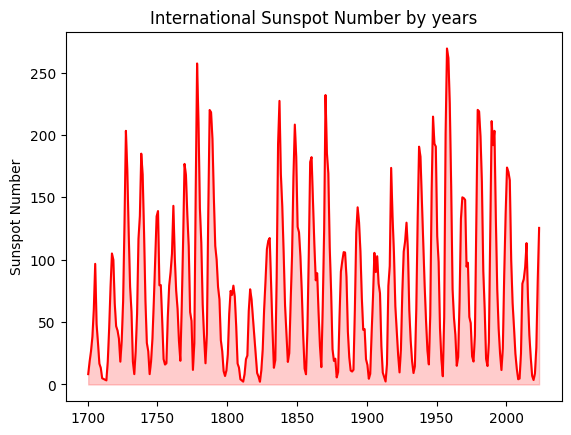

In [7]:
raw_sunspots, raw_years = get_years_sunspot_dataset()
X, Y, sunsposts, years = preprocess_sunspots_data(raw_sunspots, raw_years, year=1700, n_time_step=6)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size= 0.96, shuffle=False)
plot_sunspot_number(years, sunsposts, time_unit="years", color="red", scatter=False, filled = True)



MSE con años 0.006068184342019718


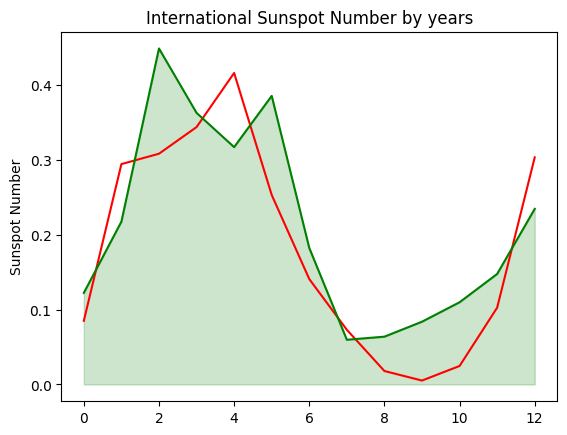

In [8]:

model_kernel_poly = KernelPolynomialRegression(gamma=0.5, alpha=0.6, degree=6, coef = 1)

# Mientras más años se den para entrenar, mejores predicciones realiza
Ws = model_kernel_poly.fit(X_train, Y_train.flatten())
Y_pred = model_kernel_poly.predict(X_test)

show_mse(Y_test, Y_pred, "MSE con años")
plot_sunspot_number(range(Y_test.shape[0]), Y_test, color="red", time_unit="years")
plot_sunspot_number(range(Y_pred.shape[0]), Y_pred, color="green", time_unit="years", filled=True)

In [9]:
sklearn_kernel_ridge = KernelRidge(alpha=0.01, kernel='rbf', gamma=10)
sklearn_kernel_ridge.fit(X_train,Y_train)

Y_pred = sklearn_kernel_ridge.predict(X_test)

kernel_ridge_error = mean_squared_error(Y_test, Y_pred)
print(kernel_ridge_error)


0.010534573720965407


In [10]:
support_vector_machine = svm.SVR(kernel='rbf',  C=1e4, gamma=10)
support_vector_machine.fit(X_train,Y_train)
Y_pred = support_vector_machine.predict(X_train)
svm_error = mean_squared_error(Y_train, Y_pred)
print(svm_error)

0.004916259768203325


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Caso de meses

### Carga de manchas solares por meses

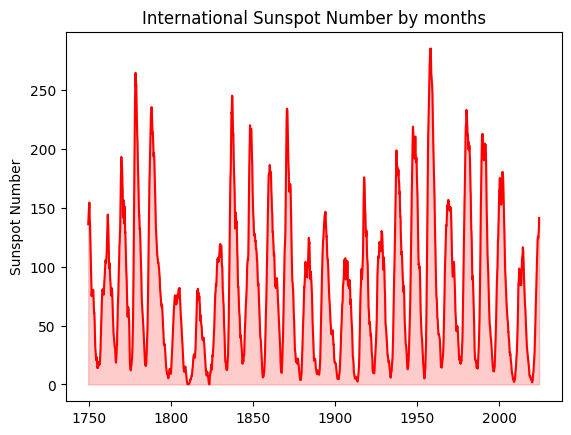

In [11]:
raw_sunspots_months, raw_months = get_ms_sunspot_dataset()

X, Y, sunsposts_months, months = preprocess_sunspots_data(raw_sunspots_months, raw_months, 1700, 2)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size= 0.96, shuffle=False)

plot_sunspot_number(months, sunsposts_months, time_unit="months", color="red", scatter=False, filled = True)




MSE with months:  9.403281410426359e-05


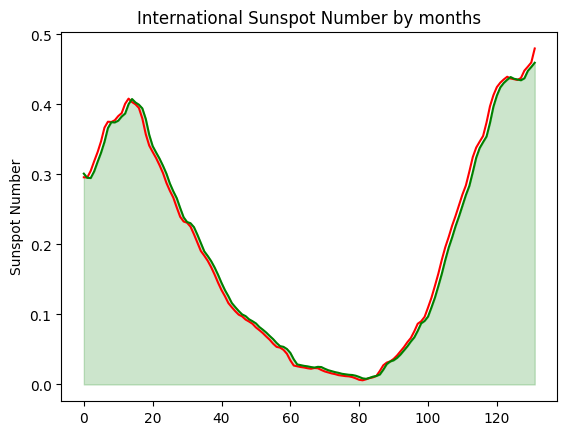

In [12]:

model_kernel_poly = KernelPolynomialRegression(gamma=1.5, alpha=0.4, degree=3, coef = 1)

# Ahora que tenemos mas datos, la prediccion se ajusta aun mejor
Ws = model_kernel_poly.fit(X_train, Y_train.flatten())
Y_pred = model_kernel_poly.predict(X_test)

show_mse(Y_test, Y_pred, "MSE with months: ")
plot_sunspot_number(range(Y_test.shape[0]), Y_test, color="red", time_unit="months")
plot_sunspot_number(range(Y_pred.shape[0]), Y_pred, color="green", time_unit="months", filled=True)

In [13]:
sklearn_kernel_ridge = KernelRidge(alpha=0.01, kernel='rbf', gamma=10)
sklearn_kernel_ridge.fit(X_train,Y_train)

Y_pred = sklearn_kernel_ridge.predict(X_test)

kernel_ridge_error = mean_squared_error(Y_test, Y_pred)
print(kernel_ridge_error)


9.209425470743998e-05


In [14]:
support_vector_machine = svm.SVR(kernel='rbf',  C=1e4, gamma=10)
support_vector_machine.fit(X_train,Y_train)
Y_pred = support_vector_machine.predict(X_train)
svm_error = mean_squared_error(Y_train, Y_pred)
print(svm_error)

0.001918740199397057


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Caso de dias

Para este caso necesitaremos optimizar con decenso de gradiente

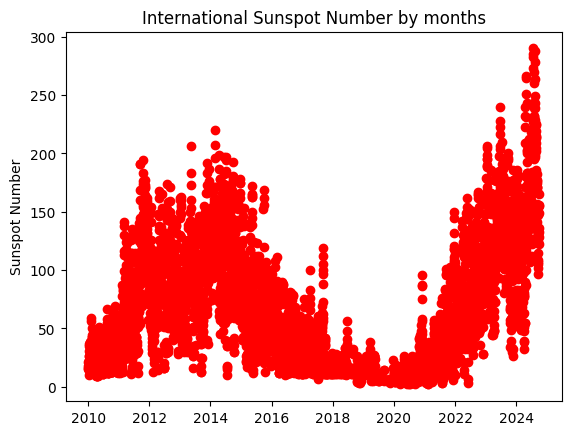

In [15]:
raw_sunspots_days, raw_days = get_days_sunspot_dataset()

X, Y, sunsposts_days, days = preprocess_sunspots_data(raw_sunspots_days, raw_days, 2010, 2)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size= 0.96, shuffle=False)

plot_sunspot_number(days, sunsposts_days, time_unit="months", color="red", scatter=True, filled = True)



In [16]:

# En general esta clase no deberia existir, se repite mucho codigo
class KernelPolynomialRegressionGDE:
    kernel_matrix: np.ndarray = None
    W: np.ndarray = None
    alpha = 0
    coef = 0
    gamma = 0
    X_fit: np.ndarray = None

    def __init__(self, alpha = 0.001, gamma = 1.0, degree = 2, coef = 1):
        self.alpha = alpha
        self.gamma = gamma
        self.degree = degree
        self.coef = coef

    def kernel(self, x_i: np.ndarray, x_j: np.ndarray):
        return (self.gamma*np.dot(x_i, x_j.T) + self.coef )**self.degree

    def __build_kernel_matrix(self, X1 : np.ndarray, X2 : np.ndarray) -> np.ndarray:
        kernel_matrix=np.zeros((X1.shape[0],X2.shape[0]))
        for i, _ in enumerate(kernel_matrix):
            for j, _ in enumerate(kernel_matrix.T):
                kernel_matrix[i,j]=self.kernel(X1[i],X2[j])
        return kernel_matrix
    
    def __apply_regularization_l2(self,kernel_matrix): 
        kernel_matrix_regulated = kernel_matrix.copy() + np.identity(kernel_matrix.shape[0]) * self.alpha
        return kernel_matrix_regulated
        
    def __mse(self, y_true, y_pred):
        return  mean_squared_error(y_true,y_pred)

    def __bakward_prop(self, y_true, y_pred, row_kernel_matrix, learning_rate):
        return self.W.copy() - learning_rate * ((y_pred - y_true) * row_kernel_matrix + 2 * self.alpha * self.W)

    def __feedfoward_prop(self,X: np.ndarray, row_kernel_matrix: np.ndarray):
        return np.array([np.matmul(self.W, row_kernel_matrix)])

    def fit(self, X : np.ndarray, Y : np.ndarray, epochs = 1, learning_rate = 0.01, verbose = True):
        assert isinstance(X,np.ndarray), "X must be a np.array"
        assert isinstance(Y,np.ndarray), "Y must be a np.array"
        assert X.shape[0] == Y.shape[0], "X and Y must have same len"
        
        self.X_fit = X.copy()
        kernel_matrix = self.__build_kernel_matrix(X, self.X_fit)
        self.W = 2 * np.random.random(size=(X.shape[0])) - 1
        
        if ( len(Y.shape) == 1):
            Y = Y.reshape(-1,1)
        history = np.zeros(epochs)
        for epoch in range(epochs):
            y_pred = np.zeros(Y.shape[0])
            for i in range(X.shape[0]):
                y_pred[i] = self.__feedfoward_prop(X[i], kernel_matrix[i])
                self.W = self.__bakward_prop(Y[i], y_pred, kernel_matrix[i], learning_rate)
            history[epoch] = mean_squared_error(Y, y_pred)
            if ( verbose ):
                print(f"{epoch + 1} / {epochs}: loss: {mean_squared_error(Y, y_pred)}")

        return self.W, history

    def predict(self, X):
        pred_dim = X.shape[0]
        Y_pred = np.zeros((pred_dim,1))
        kernel_matrix = self.__build_kernel_matrix(X,self.X_fit)
        for i in range(pred_dim):
            Y_pred[i] = np.matmul(self.W, kernel_matrix[i])
        return Y_pred


In [ ]:
model_kernel_poly = KernelPolynomialRegressionGDE(gamma=0.07, alpha=0.001, degree=2, coef = 0.0825)

# Ahora que tenemos mas datos, la prediccion se ajusta aun mejor
Ws, history = model_kernel_poly.fit(X_train, Y_train.flatten(), epochs=10, learning_rate=0.001, verbose=False) 
Y_pred = model_kernel_poly.predict(X_test)



MSE days 0.03158715408480226


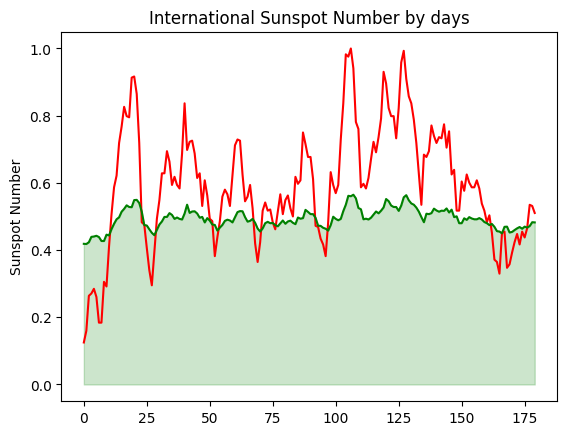

In [20]:
show_mse(Y_test, Y_pred, "MSE days")
plot_sunspot_number(range(Y_test.shape[0]), Y_test, color="red", time_unit="days")
plot_sunspot_number(range(Y_pred.shape[0]), Y_pred, color="green", time_unit="days", filled=True)

### Conclusion
Con respecto a la regresion polinomica, podemos contemplar como hiperparametro el grado del polinomio resultante. Esto se debe a que se busca un vector de grado N que permita que el problema sea linealmente separable. La busqueda de este parametro puede ser automatizado aplicando criterio de información bayesiano, sin embargo, este algoritmo requiere de mucho computo para ejecutar, debido a que se debe realizar la siguiente multiplicacion de matrices:
$$
\phi(x) \cdot \phi^T(x)
$$
Con respecto a la regresion lineal con Ridge usando el metodo de kernel polinomica, el cual es el siguiente:
$$
K(X, Y) = (\gamma \langle X, Y \rangle + \text{coef0})^{\text{d}}
$$

En este caso, se dejo el parametro del coeficinete por defecto. En el caso del parametro del grado de la dimension, permite que las predicciones se ajusten mejor al comportamineto de la grafica, pero al ser muy alto, puede traer sobreajuste. Es con ello que, el parametro alpha, utilizado para la regularizacion L2. Mientras mayor sea, mas ruido se le agrega a la prediccion final.

Ahora se utiliza la maquina de soporte de vectores usando el kernel de Radial Basis Function (RBF)
$$
K(x, x') = \exp\left(-\frac{\|x-x'\|^2}{2\sigma^2}\right)
$$
En este caso tambien utilizamos el parametro C para la regularizacion L2 ya que tenemos un sigma que puede dar pie a sobreajuste.




